# Classifier for lines

This workbook builds a classifier for classifying the lines based on the exported data.

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [4]:
dfLinesAll = pd.read_csv('./gerrit_review_for_classifier_wireshark.csv', sep='$')

In [6]:
# we need to replate the name of the column in case it is "fit"
# this is a limitation of the classifiers in Python
dfLinesAll = dfLinesAll.rename(columns = {'fit': 'fit_feature'})

In [7]:
# this is just for our information
# shows how balanced/imbalanced classes we have
# for a good training accuracy, we need to have as close to 50-50 as possible
dfLinesAll.groupby('class_value')['LOC'].count()

class_value
0    334
1     73
Name: LOC, dtype: int64

In [8]:
X = dfLinesAll.drop(['class_value', 'LOC', 'filename'], axis=1)
y = dfLinesAll['class_value']

In [9]:
# splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [10]:
# if we have unbalanced classes, we need to upsample/downsample
# this script does the upsampling
index_class_0 = np.where( y_train == 0 )[0]
index_class_1 = np.where( y_train == 1 )[0]

# Number of observations in each class
n_class0 = len(index_class_0)
n_class1 = len(index_class_1)

# For every observation in class 0, randomly sample from class 1 with replacement
i_class1_upsampled = np.random.choice(index_class_1, size=n_class0, replace=True)

In [11]:
# Join together class 1's upsampled target vector with class 0's target vector
y_train2 = np.concatenate((y_train[y_train.index[i_class1_upsampled]], y_train[y_train.index[index_class_0]]))
X_train2 = np.concatenate((X_train.iloc[i_class1_upsampled], X_train.iloc[index_class_0]))

In [12]:
ab_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
        ('ab', AdaBoostClassifier(DecisionTreeClassifier(max_depth=100), n_estimators=200, algorithm="SAMME.R", learning_rate=0.2)),
    ])

ab_pipeline.fit(X_train2, y_train2)

Pipeline(memory=None,
         steps=[('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ab',
                 AdaBoostClassifier(algorithm='SAMME.R',
                                    base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                          class_weight=None,
                                                                          criterion='gini',
                                                                          max_depth=100,
                                                                          max_features=None,
                                                                          max_leaf_nodes=None,
                                                                          min_impurity_decrease=0.0,
                                                                          min_impurity_split=None,
                                        

# Model validation

In [15]:
from sklearn.metrics import f1_score
y_pred = ab_pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {acc:.3f}, F1: {f1:.3f}')

Accuracy: 0.722, F1: 0.230


## Visualization of the results as a confusion matrix

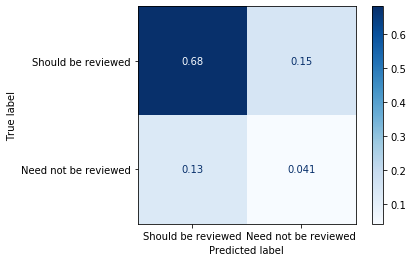

In [25]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

class_names = ['Should be reviewed', 'Need not be reviewed']
plot_confusion_matrix(ab_pipeline, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, normalize='all')